In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()

## Sigmoids
Generate mixture of two sigmoids as the SLA data. A combination of sigmoids is not a sigmoid and we assume may have characteristics that will be good to attempt forecasting using a traditional SARIMAX model. These models at their core require that the series be stationary. Stationarity of a timeseries implies that the statistical properties of the variables be the same across different portions. If we assume that a random variable is associated with each time step t, then the unconditional joint distribution is the same for all times. Clearly this is violated if we have trend or seasonality in data. And so a major portion of the modeling requires that we eliminate the trend and seasonailty. What remains after the removal of the trend and seasonality is a distribution that can be attempted to be learnt by the timeseries model. This residual is modeled well. Now, in order to forecast for a future time, we need to reintroduce the trend and seasonality values during prediction (or forecasting as it is called in timeseries literature).

In [2]:
np.random.seed(137777)
def gen_sigmoids(b1=0.3, b2=5., s=.8):
    x = np.linspace(-12,12,60*24)
    α = [0.01, 0.1, 1, 3, 10, 100]
    # b = np.random.choice(α)
    b = b1
    t = s*np.random.randn()
    ϵ = 0.0001*np.random.randn(x.shape[0]) #noise term
    y1 = [ 1/(1+np.exp(-(a-t) * b)) + c for a, c in zip(x, ϵ)]
    ϵ = 0.0001*np.random.randn(x.shape[0]) #noise term
    # b = np.random.choice(α)
    b = b2
    t = s*np.random.randn()
    y2 = [ 1/(1+np.exp(-(a-t) * b)) + c for a, c in zip(x, ϵ)]
    y = [(p+q)/2. for p, q in zip(y1, y2) ]
    return zip(x, y)

Text(0.5, 1.0, 'Mixture of sigmoids')

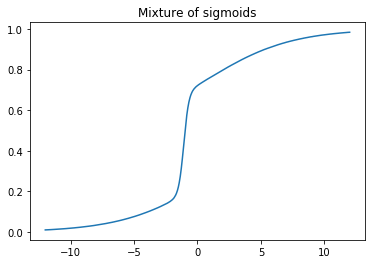

In [3]:
df = pd.DataFrame(list(gen_sigmoids()), columns={'x', 'y'})
plt.plot(df.x, df.y)
plt.title('Mixture of sigmoids')

In [4]:
df.head()


x         y
0 -12.000000  0.010823
1 -11.983322  0.010844
2 -11.966644  0.010804
3 -11.949965  0.010904
4 -11.933287  0.010994

In [5]:
# Ensure that the dataframe y values are within (0,1)
assert((df.head().y < 1).all())
assert((df.head().y > 0).all())
assert((df.tail().y < 1).all())
assert((df.tail().y > 0).all())


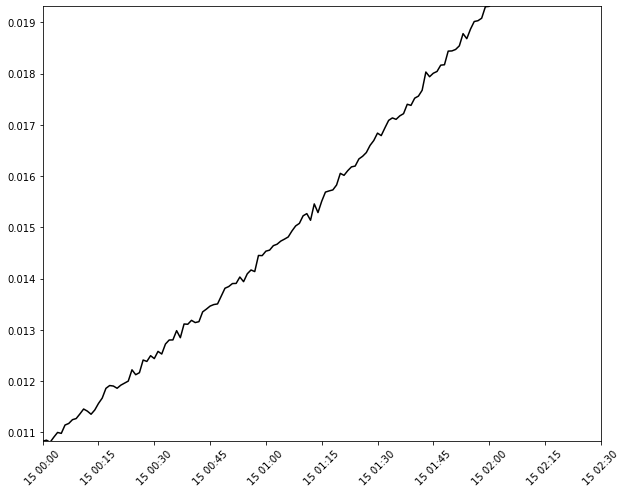

In [6]:
startstring = '2020-04-15 00:00:00'
starttime = datetime.strptime(startstring, '%Y-%m-%d %H:%M:%S')
steps = 120 #120 minutes of data to train on
def plot_start_end(df, steps):
    from datetime import timedelta
    endtime = starttime + timedelta(0,60)*steps # 120 minutes
    endstring = endtime.strftime('%Y-%m-%d %H:%M:%S') #'2020-04-15 02:00:00'

    pred_steps=30 # forecast for the next 30 minutes, 

    plotendtime = endtime + timedelta(0,60) * pred_steps
    plotendstring = plotendtime.strftime('%Y-%m-%d %H:%M:%S') #'2020-04-15 02:30:00'

    df['datetime'] = pd.date_range(start=startstring[:10], periods=24*60, freq='T') #1/minute
    df.index = df.datetime

    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(df.datetime, df.y, c='k')
    plt.xlim(starttime, plotendtime)
    plt.ylim(df[df.datetime == starttime].y[0], df[df.datetime == endtime].y[0])
    plt.xticks(rotation=45)
    return endstring, endtime, pred_steps, plotendtime, plotendstring
endstring, endtime, pred_steps, plotendtime, plotendstring = plot_start_end(df, steps)

## Timeseries EDA
A partial autocorrelation plot shows the direct autocorrelation between a series and it shifted by a certain lag without the indirect contributions of the intermediate time lags, i.e. the correlation between Y(t) and Y(t-k) without the effects of any of the intermediaries such as say, Y(t-1). This is the difference between an autocorrelation plot and the partial autocorrelation. An autocorrelation will include the effects of the all the intermediate time periods as well. The region outside the shaded region (95% confidence region) are definitely due to the presence of correlations and not due to randomness (akin to p-values being less than .05)

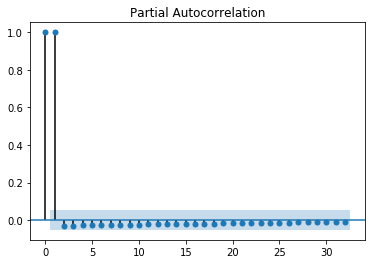

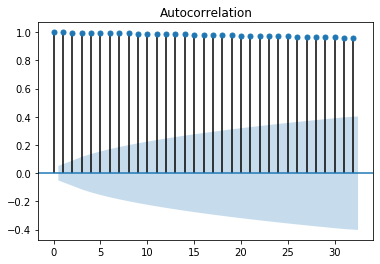

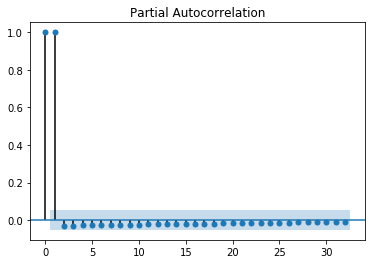

In [7]:
#Autocorrelation and partial autocorrelation plots
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(df.y)
tsaplots.plot_pacf(df.y)

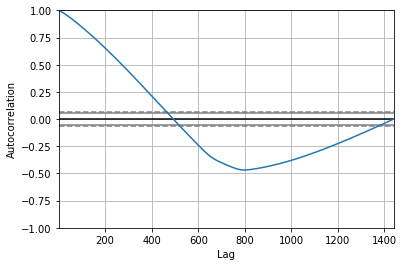

In [8]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.y)
plt.show()

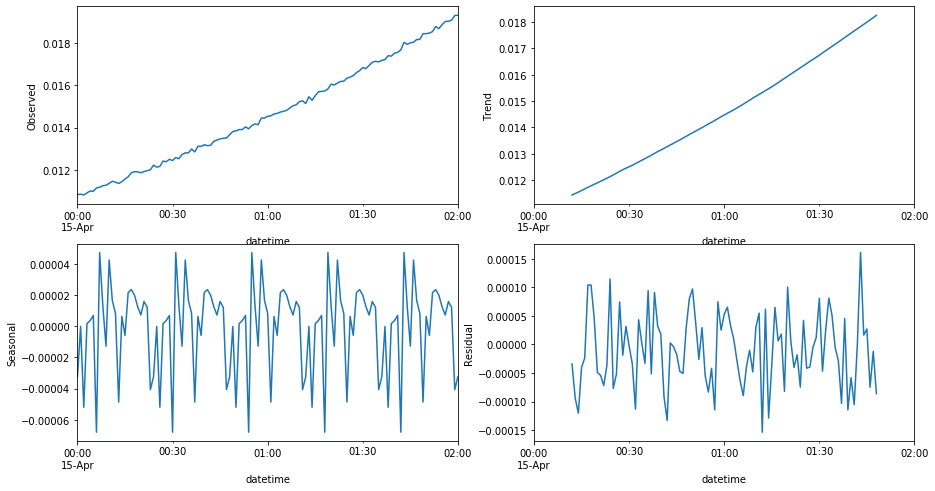

In [9]:
#
# Decompose to Trend, seasonal, and residual for steps amount of signal
#
# Trend of course is explainable due to the sigmoid trend
# seasonality is due to the additive noise
def plot_seasional(df, starttime, endtime):
    fig, ax = plt.subplots(figsize=(15,8), nrows=2, ncols=2)
    decomposition = sm.tsa.seasonal_decompose(df.y[starttime:endtime], model='additive', period=24)
    decomposition.observed.plot(ax=ax[0,0])
    ax[0,0].set_ylabel('Observed')
    decomposition.trend.plot(ax=ax[0,1])
    ax[0,1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=ax[1,0])
    ax[1,0].set_ylabel('Seasonal')
    decomposition.resid.plot(ax=ax[1,1])
    ax[1,1].set_ylabel('Residual')
plot_seasional(df, starttime, endtime)

## TSA model

In [10]:
def model_fit(df, starttime, endtime):
    data = df.loc[starttime:endtime]
    data.index = data.datetime
    # Set the frequency
    # data.index.freq="QS-OCT"
    
    # Fit the model
    mod = sm.tsa.statespace.SARIMAX(data.y, trend='c', order=(1,1,1))
    res = mod.fit(disp=False)
    print(res.summary())
    return res

In [11]:
res = model_fit(df, starttime, endtime)
data = df.loc[starttime:endtime]
rest = df.loc[endtime:]

SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 954.191
Date:                Tue, 21 Apr 2020   AIC                          -1900.382
Time:                        23:03:38   BIC                          -1889.233
Sample:                    04-15-2020   HQIC                         -1895.854
                         - 04-15-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.812e-05   6.75e-06     14.538      0.000    8.49e-05       0.000
ar.L1         -0.3840   4.37e-10  -8.79e+08      0.000      -0.384      -0.384
ma.L1         -0.0962   8.27e-11  -1.16e+09      0.000      -0.096      -0.096
sigm

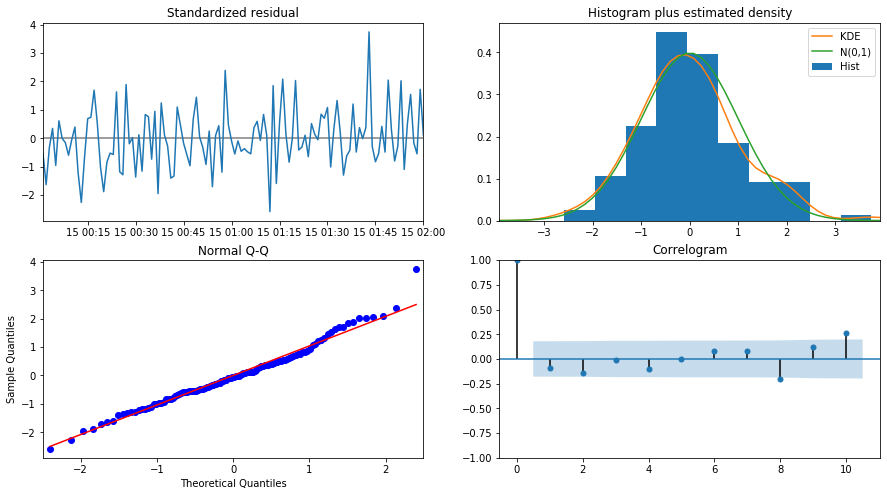

In [12]:
def plot_diagnostics(res):
    res.plot_diagnostics(figsize=(15,8))
    plt.show()
plot_diagnostics(res)

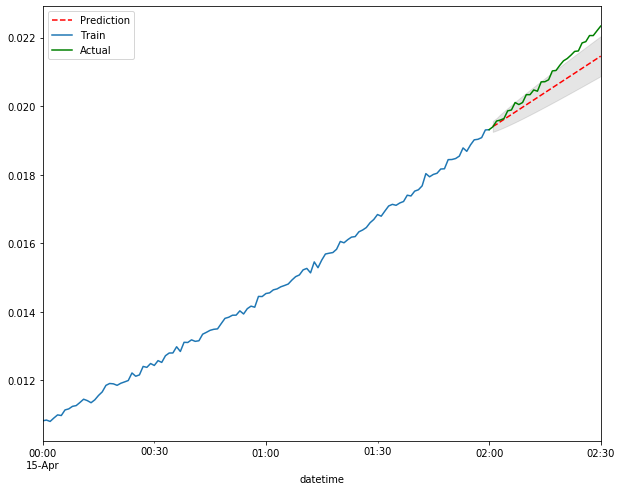

In [13]:
def plot_forecast(pred_steps, res, data, rest, startstring, endstring, plotendstring):
    fcast = res.get_forecast(pred_steps).summary_frame()
    fig, ax = plt.subplots(figsize=(10,8))
    fcast['mean'].plot(ax=ax,style='r--', label='Prediction')
    ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=.1)
    data.y.loc[startstring:endstring].plot(label='Train')
    rest.y.loc[endstring:plotendstring].plot(color='g', label='Actual')
    plt.legend()
plot_forecast(pred_steps, res, data, rest, startstring, endstring, plotendstring)

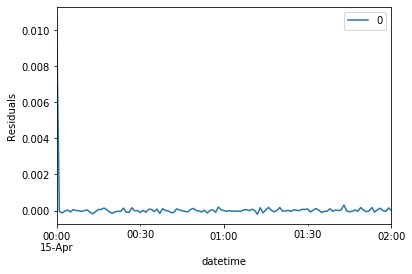

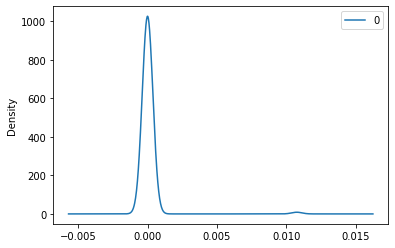

0
count  121.000000
mean     0.000089
std      0.000981
min     -0.000211
25%     -0.000049
50%     -0.000004
75%      0.000045
max      0.010752


In [14]:
# plot residual training errors, maybe not so interesting
def plot_residuals(res):
    residuals = pd.DataFrame(res.resid)
    ax = residuals.plot()
    ax.set_ylabel('Residuals')
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())
plot_residuals(res)   

## Apply the model around midday (train - 11:30 Hrs to 13:30 Hrs), forecast for 30 mins

/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 679.238
Date:                Tue, 21 Apr 2020   AIC                          -1350.475
Time:                        23:03:41   BIC                          -1339.325
Sample:                    04-15-2020   HQIC                         -1345.947
                         - 04-15-2020                                         

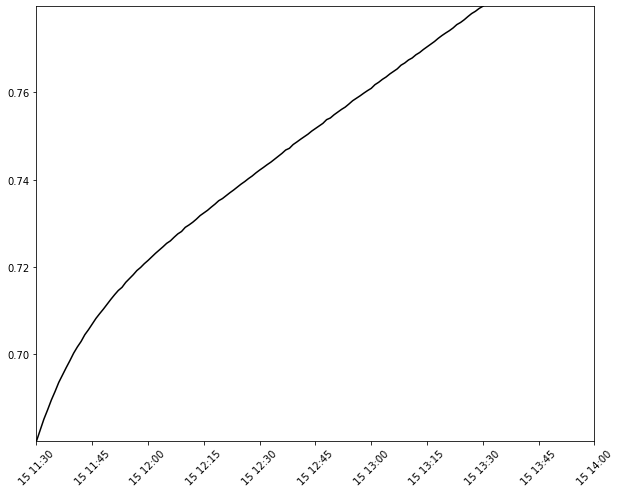

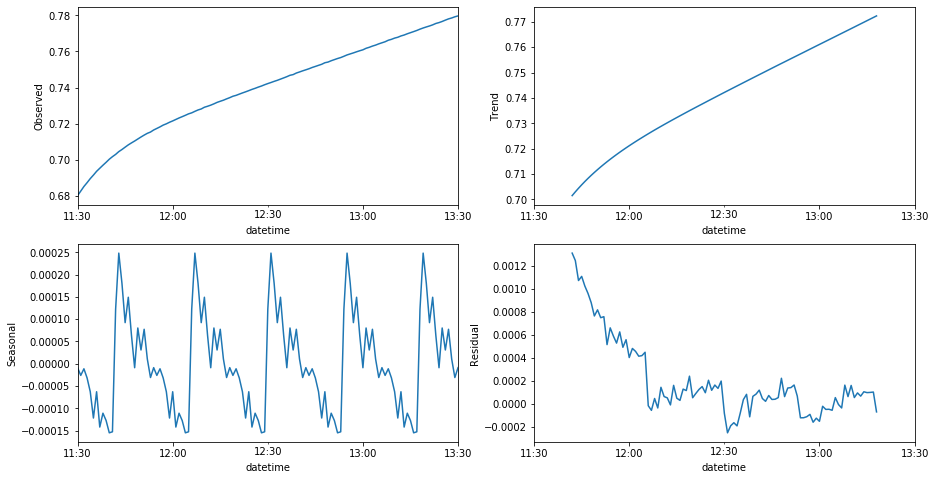

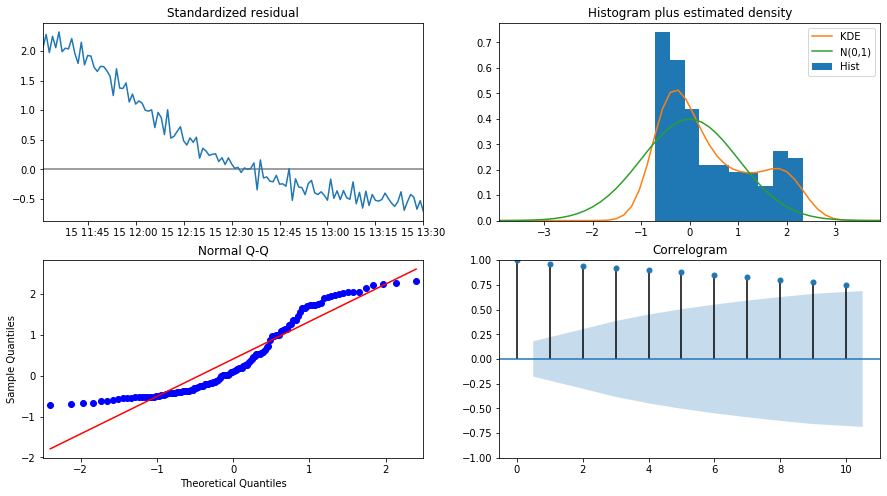

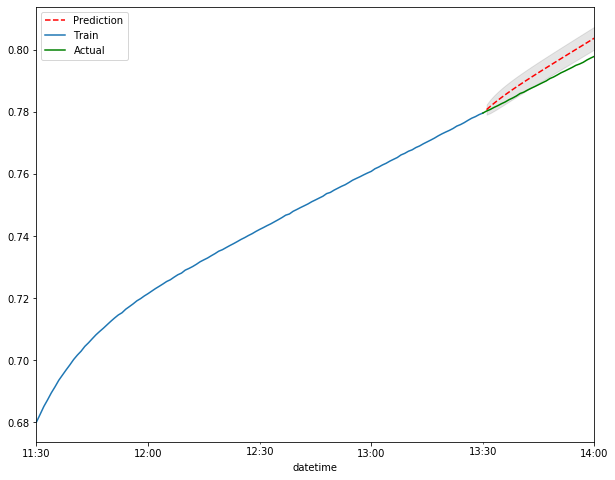

In [15]:
#Try this for a different window of time for the same data
#Midday around 12*60, when y value is 0.5
startstring = '2020-04-15 11:30:00'
starttime = datetime.strptime(startstring, '%Y-%m-%d %H:%M:%S')
#steps = 
endstring, endtime, pred_steps, plotendtime, plotendstring = plot_start_end(df,steps)
plot_seasional(df, starttime, endtime)
res = model_fit(df, starttime, endtime)
data = df.loc[starttime:endtime]
rest = df.loc[endtime:]
plot_diagnostics(res)
plot_forecast(pred_steps, res, data, rest, startstring, endstring, plotendstring)

## Same model with a training set spanning from time 00 Hrs to 11:30 Hrs

/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  691
Model:               SARIMAX(1, 1, 1)   Log Likelihood                4948.846
Date:                Tue, 21 Apr 2020   AIC                          -9889.692
Ti

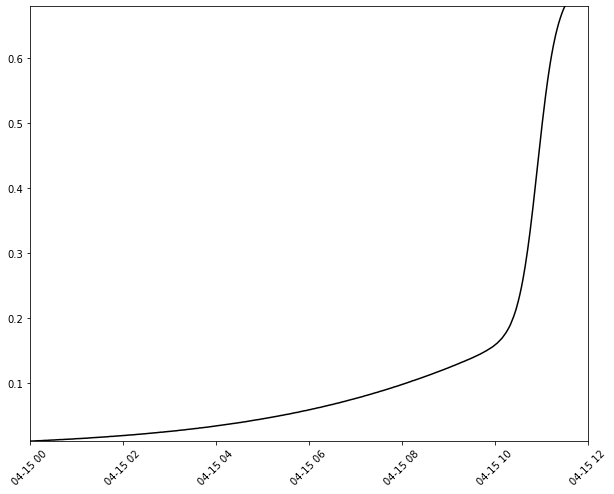

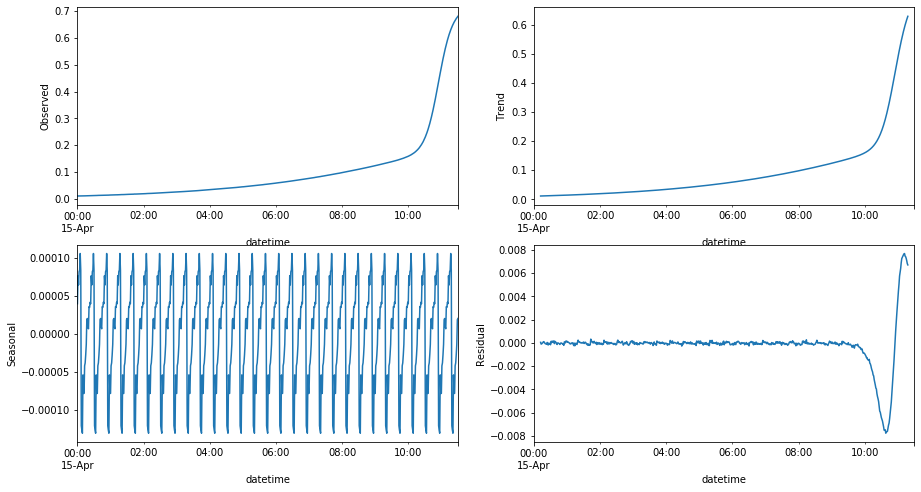

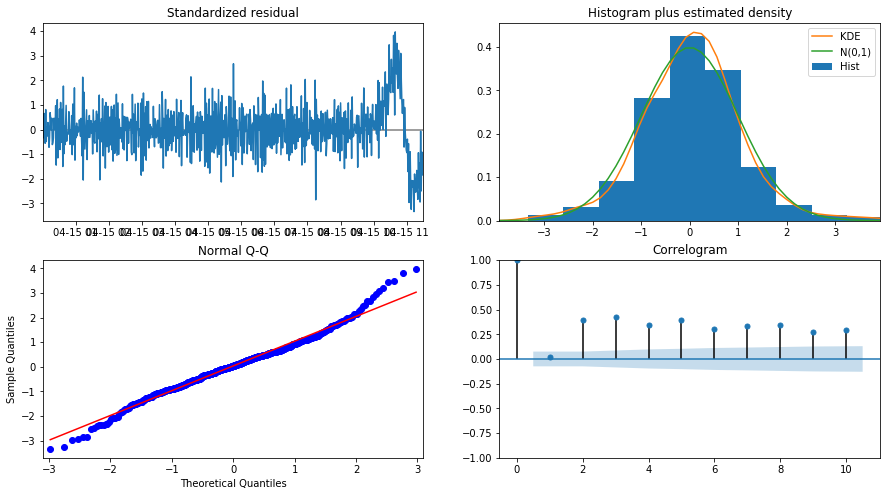

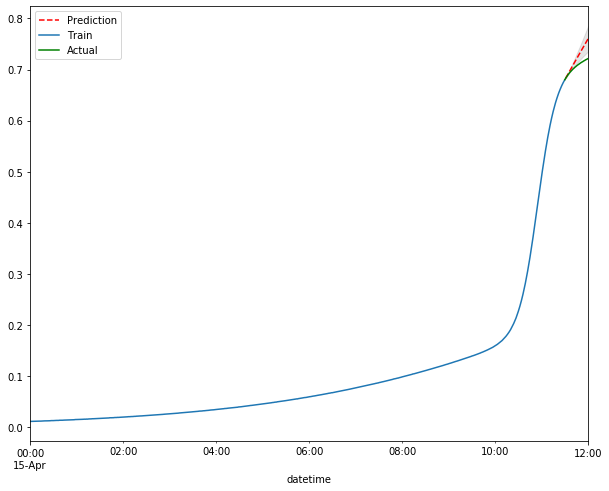

In [16]:
startstring = '2020-04-15 00:00:00'
starttime = datetime.strptime(startstring, '%Y-%m-%d %H:%M:%S')
steps = 690
endstring, endtime, pred_steps, plotendtime, plotendstring = plot_start_end(df,steps)
plot_seasional(df, starttime, endtime)
res = model_fit(df, starttime, endtime)
data = df.loc[starttime:endtime]
rest = df.loc[endtime:]
plot_diagnostics(res)
plot_forecast(pred_steps, res, data, rest, startstring, endstring, plotendstring)

## 1h window train - 11:30 Hrs-12:30 Hrs (predicting for the next 30mins)

/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/vmullachery/anaconda/envs/case_7.3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 340.790
Date:                Tue, 21 Apr 2020   AIC                           -673.581
Time:                        23:03:47   BIC                           -665.203
Sample:                    04-15-2020   HQIC                          -670.304
                         - 04-15-2020                                         

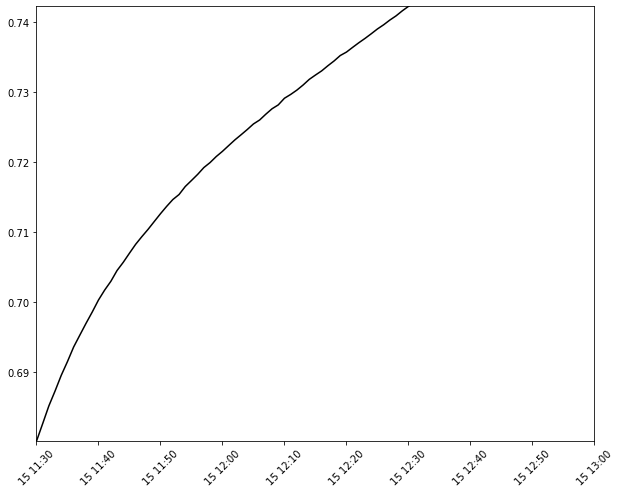

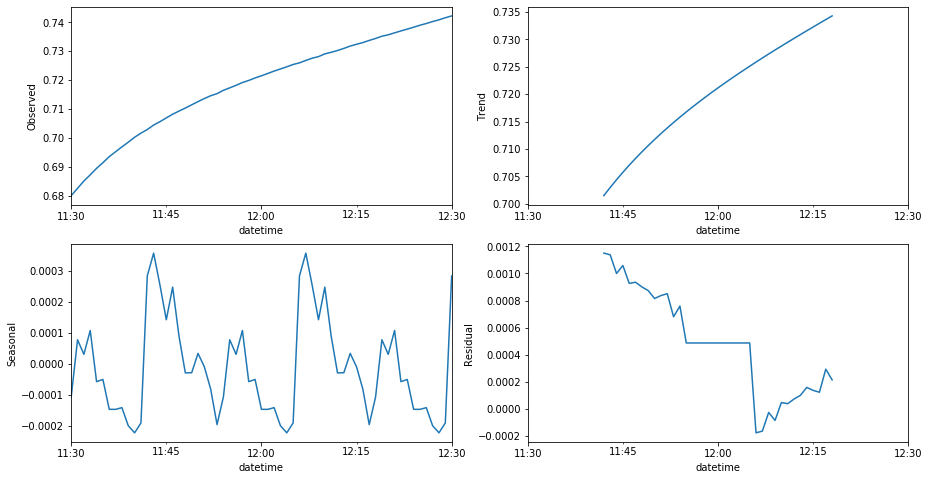

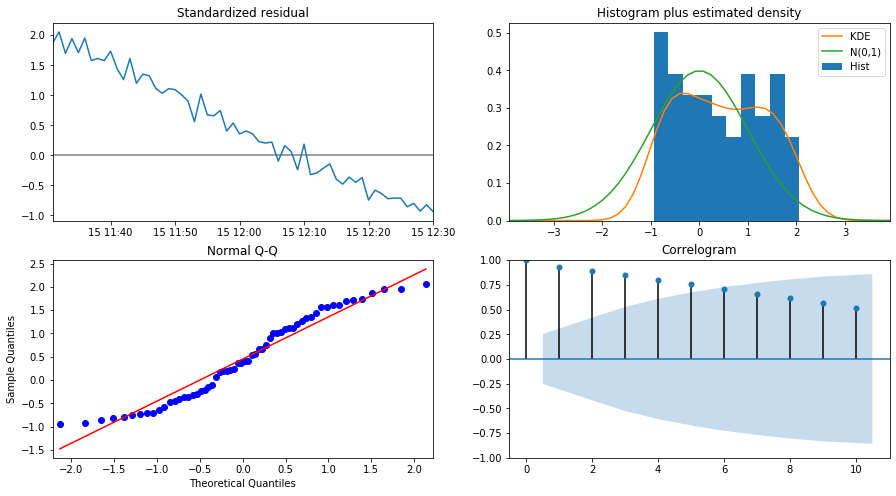

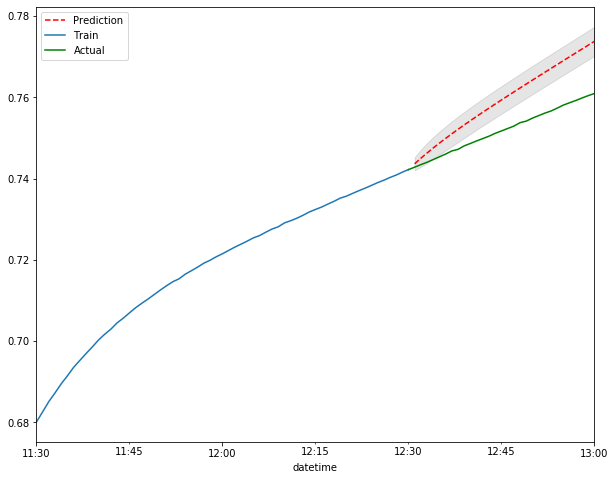

In [17]:
#Try this for a different window of time for the same data
#Midday around 12*60, when y value is 0.5
startstring = '2020-04-15 11:30:00'
starttime = datetime.strptime(startstring, '%Y-%m-%d %H:%M:%S')
steps = 60
endstring, endtime, pred_steps, plotendtime, plotendstring = plot_start_end(df,steps)
plot_seasional(df, starttime, endtime)
res = model_fit(df, starttime, endtime)
data = df.loc[starttime:endtime]
rest = df.loc[endtime:]
plot_diagnostics(res)
plot_forecast(pred_steps, res, data, rest, startstring, endstring, plotendstring)

_We notice in the above that a model trained on the entire data from 00 hours is unable to shake up it's past and it's predictions are subpar. This should motivate us to create models that are exposed to a shorter rolling window_

## Baseline Linear Model
Before we look at an RNN, let's do a baseline with a linear model, that simply uses the all the features of the previous 120 timesteps to estimate the next 1 timestep. In order to do this we will generate a set of sigmoid mixtures using our earlier code. And train our model to predict the timeseries value at the next time step

Text(0.5, 1.0, 'Mixture of sigmoids')

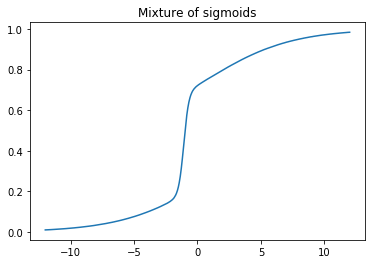

In [18]:
plt.plot(df.x, df.y)
plt.title('Mixture of sigmoids')

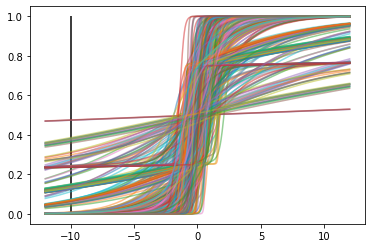

In [19]:
np.random.seed(17)
def create_samples(n_samples=40, n_begin=0, n_pred_offset=5):
    n_steps = 120
    n_total = 24*60
    left_x = -12
    ### Prediction into the future ####
    #n_pred_offset = 5
    α = [0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5, 7, 10, 20]
    X = np.empty((n_samples, n_steps))
    y = np.empty((n_samples, 1))
    for i in range(n_samples):
        b1 = np.random.choice(α)
        b2 = np.random.choice(α)
        df = pd.DataFrame(list(gen_sigmoids(b1, b2)), columns={'x', 'y'}).reset_index()
        X[i] = df[n_begin:n_begin+n_steps].y
        y[i] = df.loc[n_begin+n_steps+n_pred_offset].y
        plt.plot(df.x, df.y, label='σ mixture params: {}, {}'.format(b1, b2), alpha=0.5)
        #plt.legend(loc='upper right')
    plt.vlines(left_x + n_steps*2*abs(left_x)/n_total, 0, 1)
    plt.show()
    return X, y
X, y = create_samples(n_samples=400, n_begin=0, n_pred_offset=5)

In [20]:
X.shape, y.shape, y[0], y[1], y[-1], y[-2], # y

((400, 120),
 (400, 1),
 array([0.13041297]),
 array([0.06524189]),
 array([0.00362672]),
 array([0.00342403]))

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
def create_dfs(X_train, y_train, X_test, y_test):
    df_train = pd.DataFrame(X_train)
    a = df_train.columns
    b = ['s' + str(i) for i in a]
    df_train = df_train.rename(columns=dict(zip(a,b)))
    df_train = pd.concat((df_train, pd.Series(y_train[:,0]).rename('y')), axis=1)
    
    df_test = pd.DataFrame(X_test)
    a = df_test.columns
    b = ['s' + str(i) for i in a]
    df_test = df_test.rename(columns=dict(zip(a,b)))
    df_test = pd.concat((df_test, pd.Series(y_test[:,0]).rename('y')), axis=1)
    return df_train, df_test

import statsmodels.formula.api as smf
def train_model(df_train):
    reg_formula = 'y ~ ' + ' + '.join(str(col) for col in df_train.columns if col != 'y')
    #print(reg_formula)

    model_all = smf.ols(formula = reg_formula, data = df_train).fit()
    print(model_all.summary())
    return model_all

In [22]:
df_train, df_test = create_dfs(X_train, y_train, X_test, y_test)
model_all = train_model(df_train)

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.255e+06
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:03:58   Log-Likelihood:                 2994.2
No. Observations:                 360   AIC:                            -5746.
Df Residuals:                     239   BIC:                            -5276.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.255e-06   6.62e-06      1.398      0.163   -3.79e-06    2.23e-05
s

In [23]:
# Source: 
# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
#from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    # print(y_true.shape, y_pred.shape)
    if len(y_true.shape) == 2:
        y_true = np.squeeze(y_true, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.squeeze(y_pred, axis=1)
    assert(y_true.shape == y_pred.shape)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model_all.predict(df_test)
#mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), 
mean_absolute_percentage_error(y_test, y_pred)

156.66469495533067

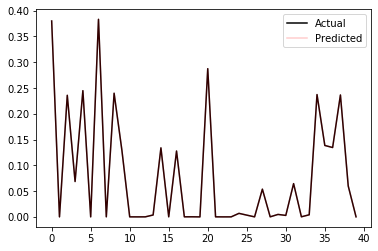

In [25]:
plt.plot(list(range(len(y_test))), y_test, c='k', label='Actual')
plt.plot(list(range(len(y_pred))), y_pred, c='r', alpha=.2, label='Predicted')
plt.legend()


### So that the tells us that a simple linear model is amazingly good??? (0.76% MAPE) for a sigmoid in predicting 5 time steps into the future in the lefthand most region (around time 00:00 Hrs). But did we notice the large condition number and the high p-values?

### Let's try around 11:30 Hrs


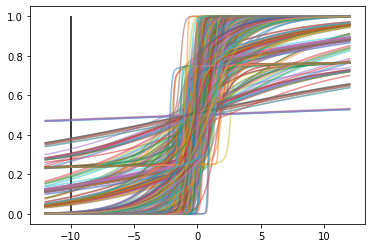

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.904e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:04:07   Log-Likelihood:                 1880.2
No. Observations:                 360   AIC:                            -3518.
Df Residuals:                     239   BIC:                            -3048.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0030      0.001      4.739      0.000       0.002       0.004
s

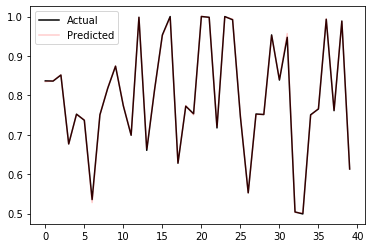

In [26]:
#24*60 == 24hrs, 12*60 == 12Hrs, 12*60 - 30 == 11:30Hrs
X, y = create_samples(n_samples=400, n_begin=690, n_pred_offset=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
df_train, df_test = create_dfs(X_train, y_train, X_test, y_test)
model_all = train_model(df_train)
y_pred = model_all.predict(df_test)
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
plt.plot(list(range(len(y_test))), y_test, c='k', label='Actual')
plt.plot(list(range(len(y_pred))), y_pred, c='r', alpha=.2, label='Predicted')
plt.legend()


### Let's try around 11:30 Hrs with a prediction offset of 30 (minutes)


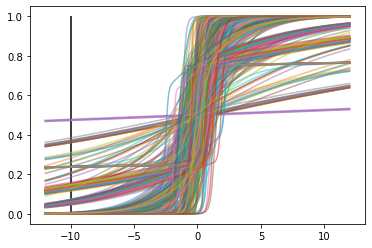

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     232.9
Date:                Tue, 21 Apr 2020   Prob (F-statistic):          1.66e-200
Time:                        23:04:16   Log-Likelihood:                 1062.6
No. Observations:                 360   AIC:                            -1883.
Df Residuals:                     239   BIC:                            -1413.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0450      0.007      6.785      0.000       0.032       0.058
s

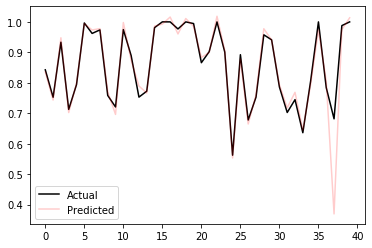

In [27]:
#24*60 == 24hrs, 12*60 == 12Hrs, 12*60 - 30 == 11:30Hrs
X, y = create_samples(n_samples=400, n_begin=690, n_pred_offset=30)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
df_train, df_test = create_dfs(X_train, y_train, X_test, y_test)
model_all = train_model(df_train)
y_pred = model_all.predict(df_test)
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
plt.plot(list(range(len(y_test))), y_test, c='k', label='Actual')
plt.plot(list(range(len(y_pred))), y_pred, c='r', alpha=.2, label='Predicted')
plt.legend()


### MAPE 0.068 ??? - that's appears good. But did we notice the large condition number and the high p-values?

### Let's try around 11:30 Hrs and prediction offset to 120 (minutes)


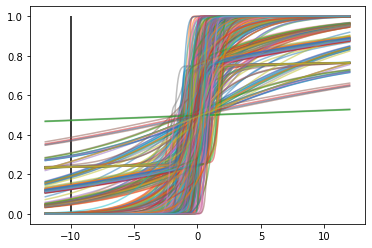

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     18.00
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           4.30e-75
Time:                        23:04:25   Log-Likelihood:                 632.41
No. Observations:                 360   AIC:                            -1023.
Df Residuals:                     239   BIC:                            -552.6
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1996      0.022      8.979      0.000       0.156       0.243
s

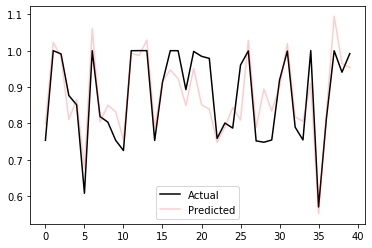

In [28]:
#24*60 == 24hrs, 12*60 == 12Hrs, 12*60 - 30 == 11:30Hrs
X, y = create_samples(n_samples=400, n_begin=690, n_pred_offset=120)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
df_train, df_test = create_dfs(X_train, y_train, X_test, y_test)
model_all = train_model(df_train)
y_pred = model_all.predict(df_test)
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
plt.plot(list(range(len(y_test))), y_test, c='k', label='Actual')
plt.plot(list(range(len(y_pred))), y_pred, c='r', alpha=.2, label='Predicted')
plt.legend()


In [32]:
print('MAPE: {}'.format(mean_absolute_percentage_error(np.array([1.0]), np.array([0.9]))))


MAPE: 9.999999999999998


### MAPE of 0.76??? -- that's good as well. But did we notice the large condition number and the high p-values?


### The benefits of a Recurrent Neural Network to timeseries is that we do not have to manually reconcile the trend and seasonality as we had to for the traditional time series models. RNNs are especially good when using GRUs or LSTM gates.


### However all these approaches are only pattern matchers and are NOT reliant on the mechanics and logistics of the business, such as the velocity of transportation of items from the main location to the agencies, the flow of packages between their various states. The features that are indicative of these mechanics can be constructed from their visible aggregate indicators, such as the count of packages transitioning from a particular state (for e.g. held at the main distribution center) to their next state (say enroute to the agency) within each minute. My conjecture is that modeling this as a series of state transitions and writing down their flow as an ODE (ordinary differential equation) could yield some helpful insights, if not predictions

In [29]:
from tensorflow import keras
n_steps=120
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps,1]),
    keras.layers.Dense(1)
])
